In [1]:
import os
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend([os.path.abspath('..')])

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] on linux


In [2]:
from denoising.helpers import *
from denoising.metrics import ICC
from nilearn.connectome import sym_matrix_to_vec
from seaborn import heatmap

In [3]:
atlas = 'HCPex' # Schaefer200 AAL Brainnetome
strategy = 4

In [4]:
trt1 = fetch_ts('/data/Projects/TestRetest_NYU/TRT_outputs',
               #sub=,
               run=1, atlas_name=atlas, strategy=strategy)
trt2 = fetch_ts('/data/Projects/TestRetest_NYU/TRT_outputs',
               #sub=,
               run=2, atlas_name=atlas, strategy=strategy)
trt3 = fetch_ts('/data/Projects/TestRetest_NYU/TRT_outputs',
               #sub=,
               run=3, atlas_name=atlas, strategy=strategy)

no files available: []
no files available: []
no files available: []


In [5]:
fc_trt1 = functional_connectivity(trt1, 'correlation')
fc_trt2 = functional_connectivity(trt2, 'correlation')
fc_trt3 = functional_connectivity(trt3, 'correlation')

In [6]:
metric = ICC([fc_trt1, fc_trt2, fc_trt3])
outp = metric.icc()

0.8870559307683769


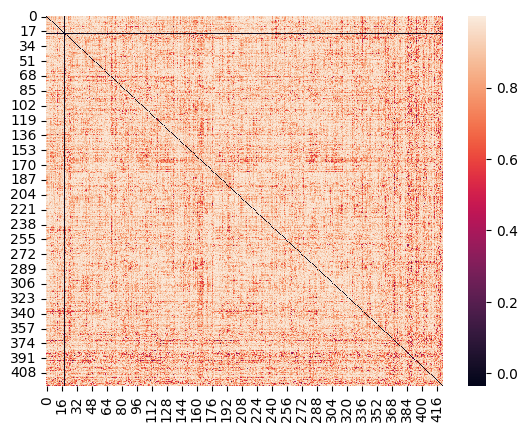

In [8]:
print(np.mean(outp))
heatmap(outp);